# Loan Sales Historical Analysis

**Author:** Data Science Team  
**Date:** 2025-11-07  
**Dataset:** loan_history.csv (1.1M+ loan records from 1900-2025)

---

## Objective

This notebook performs comprehensive exploratory data analysis (EDA) on historical loan sales data to:

1. **Understand temporal patterns** in loan issuance and amounts
2. **Identify trends and seasonality** in the time series
3. **Detect anomalies** and outliers in loan amounts
4. **Analyze quarterly aggregations** for forecasting purposes
5. **Generate insights** for predictive modeling

---

## Table of Contents

1. [Data Loading & Cleaning](#1-data-loading--cleaning)
2. [Basic Data Inspection](#2-basic-data-inspection)
3. [Temporal Analysis](#3-temporal-analysis)
4. [Quarterly Aggregation](#4-quarterly-aggregation)
5. [Loan Amount Distribution](#5-loan-amount-distribution)
6. [Time Series Decomposition](#6-time-series-decomposition)
7. [Outlier Detection](#7-outlier-detection)
8. [Statistical Tests](#8-statistical-tests)
9. [Key Insights & Recommendations](#9-key-insights--recommendations)

## Setup & Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistics and time series
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


---

## 1. Data Loading & Cleaning

In [2]:
# Load data
df_raw = pd.read_csv('data/loan_history.csv')

print(f"📊 Dataset loaded: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"📅 Date range: {df_raw['T_BDBEGINDATE'].min()} to {df_raw['T_BDBEGINDATE'].max()}")
print(f"💰 Total loan amount: ${df_raw['T_DMCREDITSUM'].sum():,.2f}")

📊 Dataset loaded: 1,148,307 rows × 3 columns
📅 Date range: 1/10/2011 to 9/9/2025
💰 Total loan amount: $3,778,644,479.35


In [3]:
# Clean and prepare data
df = df_raw.copy()

# Remove unnamed index column
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in str(col) or col.strip() == ''])

# Rename columns for clarity
df = df.rename(columns={
    'T_BDBEGINDATE': 'date',
    'T_DMCREDITSUM': 'loan_amount'
})

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')

# Remove invalid dates
initial_count = len(df)
df = df.dropna(subset=['date'])
removed_count = initial_count - len(df)

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Extract temporal features
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year_quarter'] = df['year'].astype(str) + '-Q' + df['quarter'].astype(str)
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6])

print(f"\n✅ Data cleaned successfully")
print(f"   - Removed {removed_count:,} rows with invalid dates")
print(f"   - Final dataset: {len(df):,} rows")
print(f"   - Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"   - Temporal features extracted: year, quarter, month, day_of_week")


✅ Data cleaned successfully
   - Removed 0 rows with invalid dates
   - Final dataset: 1,148,307 rows
   - Date range: 1900-01-06 to 2025-11-06
   - Temporal features extracted: year, quarter, month, day_of_week


---

## 2. Basic Data Inspection

In [4]:
# Display first and last rows
print("📋 First 10 rows:")
display(df.head(10))

print("\n📋 Last 10 rows:")
display(df.tail(10))

📋 First 10 rows:


,date,loan_amount,year,quarter,month,year_quarter,day_of_week,is_weekend
0,1900-01-06,0.01,1900,1,1,1900-Q1,5,True
1,1900-01-06,500.00,1900,1,1,1900-Q1,5,True
2,1902-08-22,500.00,1902,3,8,1902-Q3,4,False
3,1904-12-30,1500.00,1904,4,12,1904-Q4,4,False
4,1906-09-29,5000.00,1906,3,9,1906-Q3,5,True
5,2009-01-29,700.00,2009,1,1,2009-Q1,3,False
6,2009-01-29,700.00,2009,1,1,2009-Q1,3,False
7,2009-01-30,500.00,2009,1,1,2009-Q1,4,False
8,2009-01-30,500.00,2009,1,1,2009-Q1,4,False
9,2009-01-30,500.00,2009,1,1,2009-Q1,4,False



📋 Last 10 rows:


,date,loan_amount,year,quarter,month,year_quarter,day_of_week,is_weekend
1148297,2025-11-06,5000.00,2025,4,11,2025-Q4,3,False
1148298,2025-11-06,13900.00,2025,4,11,2025-Q4,3,False
1148299,2025-11-06,11300.00,2025,4,11,2025-Q4,3,False
1148300,2025-11-06,1200.00,2025,4,11,2025-Q4,3,False
1148301,2025-11-06,3000.00,2025,4,11,2025-Q4,3,False
1148302,2025-11-06,40000.00,2025,4,11,2025-Q4,3,False
1148303,2025-11-06,8500.00,2025,4,11,2025-Q4,3,False
1148304,2025-11-06,4000.00,2025,4,11,2025-Q4,3,False
1148305,2025-11-06,10000.00,2025,4,11,2025-Q4,3,False
1148306,2025-11-06,3000.00,2025,4,11,2025-Q4,3,False


In [5]:
# Data types and memory usage
print("📊 Dataset Information:\n")
df.info()

📊 Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148307 entries, 0 to 1148306
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          1148307 non-null  datetime64[ns]
 1   loan_amount   1148307 non-null  float64       
 2   year          1148307 non-null  int32         
 3   quarter       1148307 non-null  int32         
 4   month         1148307 non-null  int32         
 5   year_quarter  1148307 non-null  object        
 6   day_of_week   1148307 non-null  int32         
 7   is_weekend    1148307 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(4), object(1)
memory usage: 44.9+ MB


In [6]:
# Descriptive statistics
print("📈 Loan Amount Statistics:\n")
stats_df = df['loan_amount'].describe(percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99])
display(stats_df)

print(f"\n💡 Key Insights:")
print(f"   - Mean loan amount: ${df['loan_amount'].mean():,.2f}")
print(f"   - Median loan amount: ${df['loan_amount'].median():,.2f}")
print(f"   - Std deviation: ${df['loan_amount'].std():,.2f}")
print(f"   - Coefficient of Variation: {(df['loan_amount'].std() / df['loan_amount'].mean()):.2%}")
print(f"   - Skewness: {df['loan_amount'].skew():.2f}")
print(f"   - Kurtosis: {df['loan_amount'].kurtosis():.2f}")

📈 Loan Amount Statistics:



count   1148307.00
mean       3290.62
std        4215.63
min           0.00
1%          190.00
5%          500.00
10%         500.00
25%        1000.00
50%        2000.00
75%        3500.00
90%        8000.00
95%       12000.00
99%       20000.00
max      120000.00
Name: loan_amount, dtype: float64


💡 Key Insights:
   - Mean loan amount: $3,290.62
   - Median loan amount: $2,000.00
   - Std deviation: $4,215.63
   - Coefficient of Variation: 128.11%
   - Skewness: 3.67
   - Kurtosis: 22.04


In [7]:
# Missing values analysis
print("🔍 Missing Values Analysis:\n")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})

display(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("✅ No missing values found!")

🔍 Missing Values Analysis:



,Missing Count,Percentage


✅ No missing values found!


---

## 3. Temporal Analysis

In [8]:
# Filter to modern era (post-2009) for meaningful analysis
df_modern = df[df['year'] >= 2009].copy()

print(f"📊 Focusing on modern era: {df_modern['year'].min()}-{df_modern['year'].max()}")
print(f"   - Records: {len(df_modern):,} loans")
print(f"   - Total amount: ${df_modern['loan_amount'].sum():,.2f}")

📊 Focusing on modern era: 2009-2025
   - Records: 1,148,302 loans
   - Total amount: $3,778,636,979.34


📅 Yearly Loan Statistics:



,year,Count,Total_Amount,Mean_Amount,Median_Amount,Std_Amount
0,2009,27861,19194081.00,688.92,650.00,280.33
1,2010,74480,93514256.02,1255.56,1000.00,690.93
2,2011,122536,193854443.89,1582.02,1400.00,843.16
3,2012,154619,277064747.26,1791.92,1600.00,1062.78
4,2013,189450,360965610.52,1905.33,1650.00,1239.48
5,2014,100255,258428875.19,2577.72,2150.00,1714.26
6,2015,76308,169929349.92,2226.89,1704.42,1691.77
7,2016,22319,26121169.26,1170.36,479.00,1591.43
8,2017,31811,37587471.97,1181.59,700.00,1311.15
9,2018,37779,108078499.79,2860.81,2000.00,2617.93


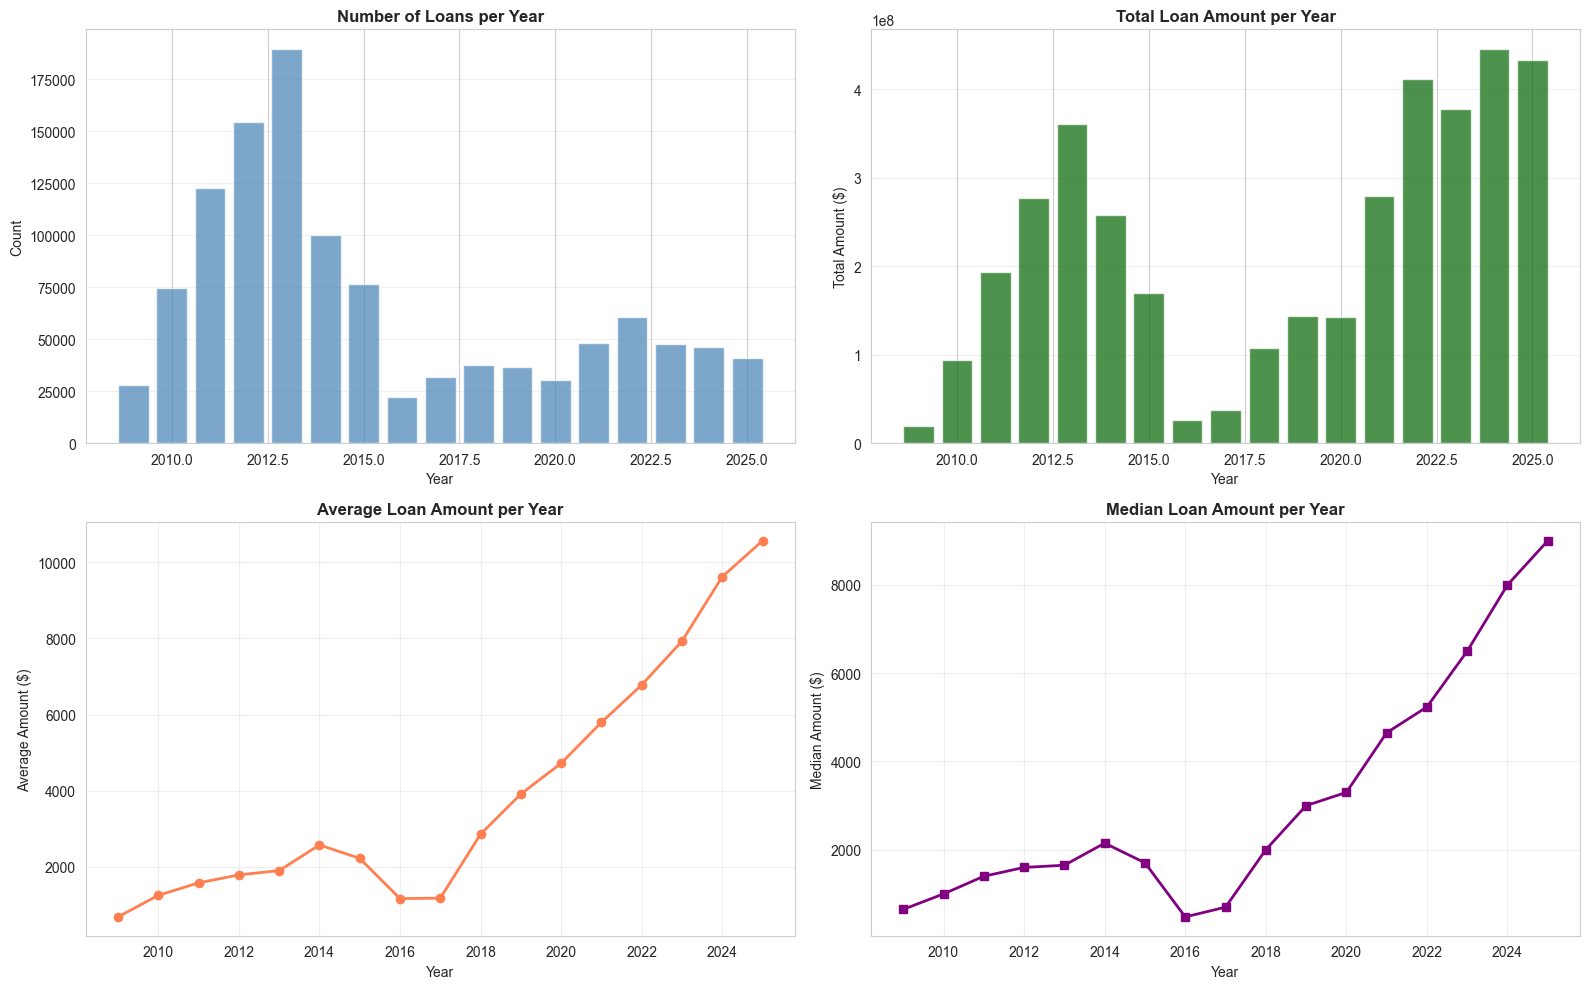

In [9]:
# Yearly trends
yearly_stats = df_modern.groupby('year').agg({
    'loan_amount': ['count', 'sum', 'mean', 'median', 'std']
}).round(2)

yearly_stats.columns = ['Count', 'Total_Amount', 'Mean_Amount', 'Median_Amount', 'Std_Amount']
yearly_stats = yearly_stats.reset_index()

print("📅 Yearly Loan Statistics:\n")
display(yearly_stats)

# Plot yearly trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loan count
axes[0, 0].bar(yearly_stats['year'], yearly_stats['Count'], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Number of Loans per Year', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# Total amount
axes[0, 1].bar(yearly_stats['year'], yearly_stats['Total_Amount'], color='darkgreen', alpha=0.7)
axes[0, 1].set_title('Total Loan Amount per Year', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Total Amount ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Average amount
axes[1, 0].plot(yearly_stats['year'], yearly_stats['Mean_Amount'], marker='o', linewidth=2, color='coral')
axes[1, 0].set_title('Average Loan Amount per Year', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Amount ($)')
axes[1, 0].grid(alpha=0.3)

# Median amount
axes[1, 1].plot(yearly_stats['year'], yearly_stats['Median_Amount'], marker='s', linewidth=2, color='purple')
axes[1, 1].set_title('Median Loan Amount per Year', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Median Amount ($)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

📅 Monthly Seasonality Patterns:



,month,Count,Mean_Amount,Median_Amount,month_name
0,1,73999,3180.28,2000.00,Jan
1,2,86128,3017.92,1600.00,Feb
2,3,89841,3166.87,2000.00,Mar
3,4,103832,3114.91,1900.00,Apr
4,5,93963,3321.63,2000.00,May
5,6,95074,3398.73,2000.00,Jun
6,7,102932,3614.95,2000.00,Jul
7,8,102922,3436.01,2000.00,Aug
8,9,102131,3241.44,1893.87,Sep
9,10,102558,3383.15,2000.00,Oct


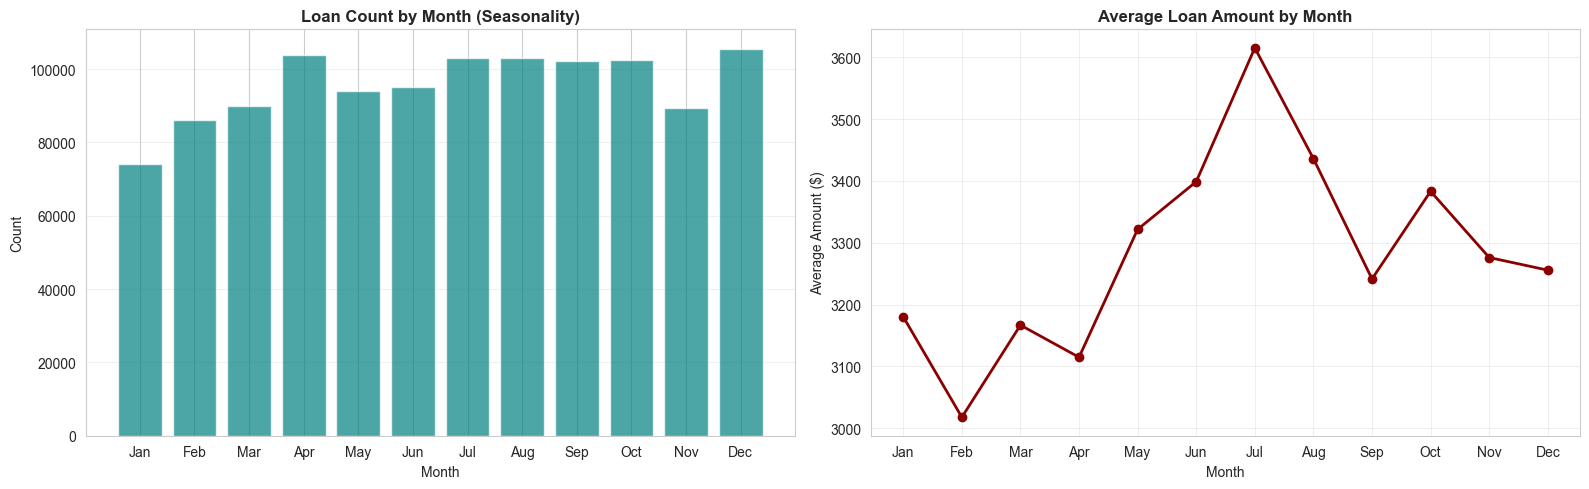

In [10]:
# Monthly patterns (seasonality)
monthly_stats = df_modern.groupby('month').agg({
    'loan_amount': ['count', 'mean', 'median']
}).round(2)

monthly_stats.columns = ['Count', 'Mean_Amount', 'Median_Amount']
monthly_stats = monthly_stats.reset_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats['month_name'] = monthly_stats['month'].apply(lambda x: month_names[x-1])

print("📅 Monthly Seasonality Patterns:\n")
display(monthly_stats)

# Plot monthly seasonality
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(monthly_stats['month_name'], monthly_stats['Count'], color='teal', alpha=0.7)
axes[0].set_title('Loan Count by Month (Seasonality)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(monthly_stats['month_name'], monthly_stats['Mean_Amount'], marker='o', linewidth=2, color='darkred')
axes[1].set_title('Average Loan Amount by Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Amount ($)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 4. Quarterly Aggregation

This section focuses on quarterly aggregations, which are critical for our forecasting models.

In [11]:
# Quarterly aggregation
quarterly = df_modern.groupby(['year', 'quarter']).agg({
    'loan_amount': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']
}).round(2)

quarterly.columns = ['Count', 'Total_Sales', 'Mean_Amount', 'Median_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount']
quarterly = quarterly.reset_index()
quarterly['year_quarter'] = quarterly['year'].astype(str) + '-Q' + quarterly['quarter'].astype(str)

print("📊 Quarterly Loan Sales Statistics (2009-2025):\n")
display(quarterly.tail(20))

# Save for modeling
quarterly.to_csv('data/quarterly_aggregated.csv', index=False)
print("\n💾 Quarterly data saved to: data/quarterly_aggregated.csv")

📊 Quarterly Loan Sales Statistics (2009-2025):



,year,quarter,Count,Total_Sales,Mean_Amount,Median_Amount,Std_Amount,Min_Amount,Max_Amount,year_quarter
48,2021,1,9355,53519179.01,5720.92,4500.00,4797.14,89.50,30000.00,2021-Q1
49,2021,2,13136,75095088.31,5716.74,4500.00,4760.73,139.00,30000.00,2021-Q2
50,2021,3,12486,71483425.20,5725.09,4500.00,4623.03,181.46,30000.00,2021-Q3
51,2021,4,13172,79064549.58,6002.47,5000.00,4653.17,284.00,30000.00,2021-Q4
52,2022,1,11665,72958306.82,6254.46,5000.00,4845.05,300.00,30000.00,2022-Q1
53,2022,2,16467,104993220.53,6375.98,5000.00,4738.09,300.00,30000.00,2022-Q2
54,2022,3,16060,108537744.59,6758.27,5400.00,4990.59,85.00,30000.00,2022-Q3
55,2022,4,16582,125488197.89,7567.74,6070.00,5544.19,67.00,50000.00,2022-Q4
56,2023,1,10653,76326940.11,7164.83,6000.00,5404.49,54.00,40000.00,2023-Q1
57,2023,2,12607,101140848.68,8022.59,6500.00,6047.38,44.00,50000.00,2023-Q2



💾 Quarterly data saved to: data/quarterly_aggregated.csv


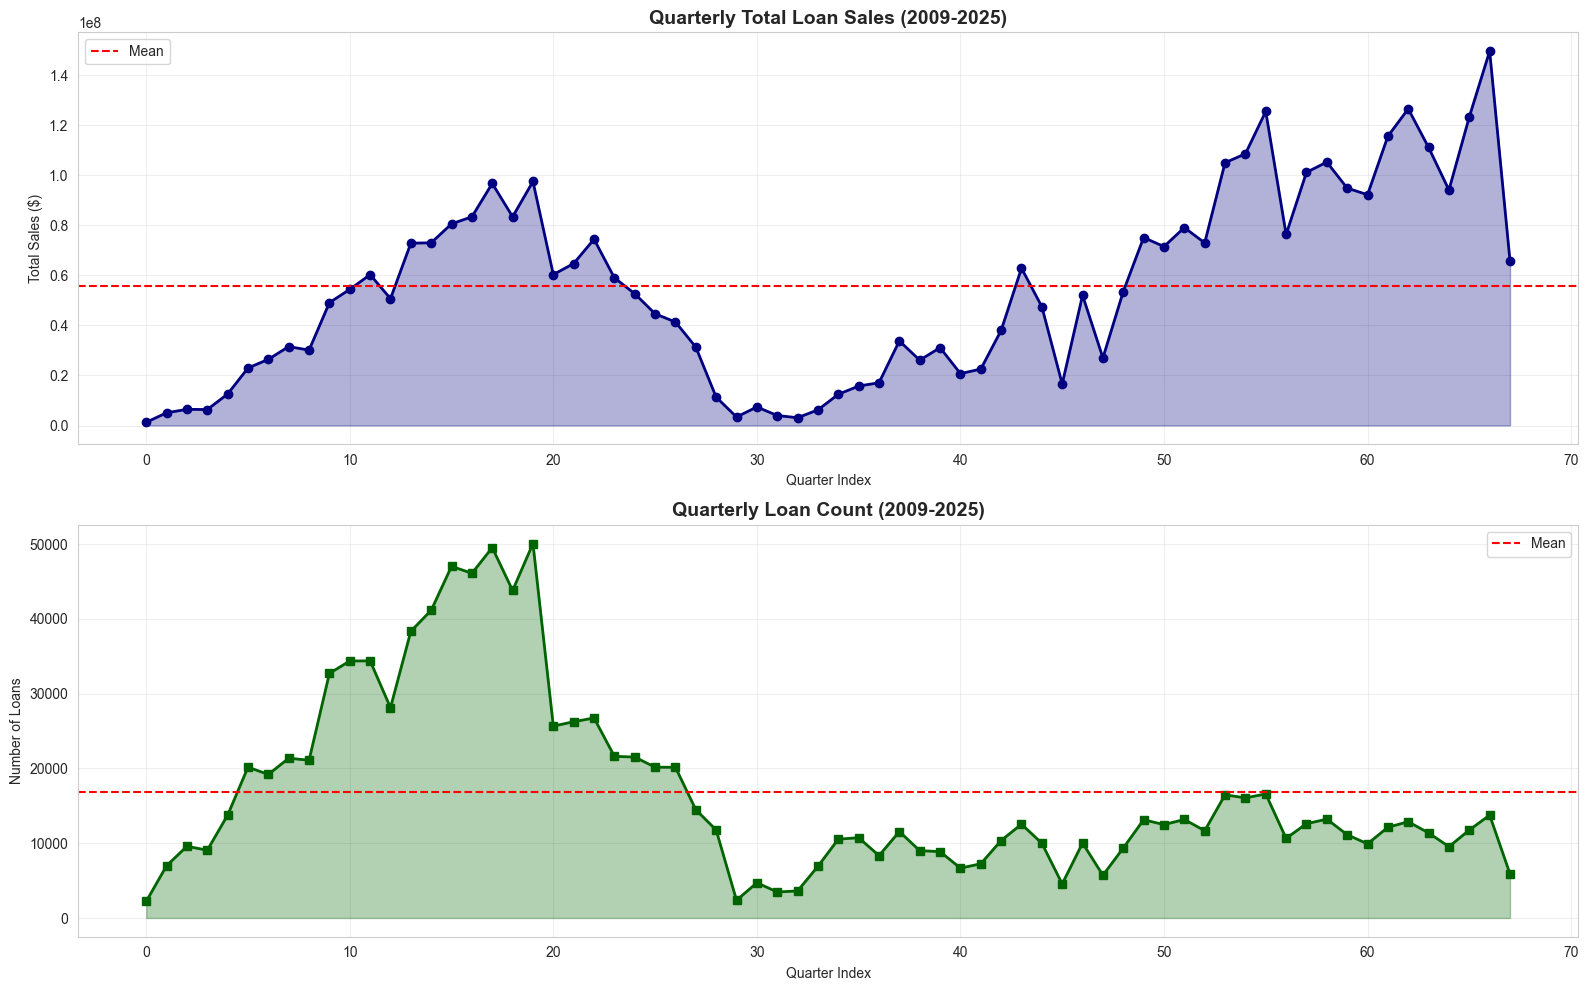

In [12]:
# Visualize quarterly trends
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Total sales per quarter
axes[0].plot(range(len(quarterly)), quarterly['Total_Sales'], marker='o', linewidth=2, color='navy')
axes[0].fill_between(range(len(quarterly)), quarterly['Total_Sales'], alpha=0.3, color='navy')
axes[0].set_title('Quarterly Total Loan Sales (2009-2025)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Quarter Index')
axes[0].set_ylabel('Total Sales ($)')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=quarterly['Total_Sales'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Loan count per quarter
axes[1].plot(range(len(quarterly)), quarterly['Count'], marker='s', linewidth=2, color='darkgreen')
axes[1].fill_between(range(len(quarterly)), quarterly['Count'], alpha=0.3, color='darkgreen')
axes[1].set_title('Quarterly Loan Count (2009-2025)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quarter Index')
axes[1].set_ylabel('Number of Loans')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=quarterly['Count'].mean(), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

📈 Recent Quarterly Growth Rates:



,year_quarter,Total_Sales,QoQ_Growth_%,YoY_Growth_%
56,2023-Q1,76326940.11,-39.18,4.62
57,2023-Q2,101140848.68,32.51,-3.67
58,2023-Q3,105230455.18,4.04,-3.05
59,2023-Q4,94828569.80,-9.88,-24.43
60,2024-Q1,92206339.03,-2.77,20.80
61,2024-Q2,115568136.23,25.34,14.26
62,2024-Q3,126500642.56,9.46,20.21
63,2024-Q4,111083720.78,-12.19,17.14
64,2025-Q1,94082928.49,-15.30,2.04
65,2025-Q2,123285801.30,31.04,6.68


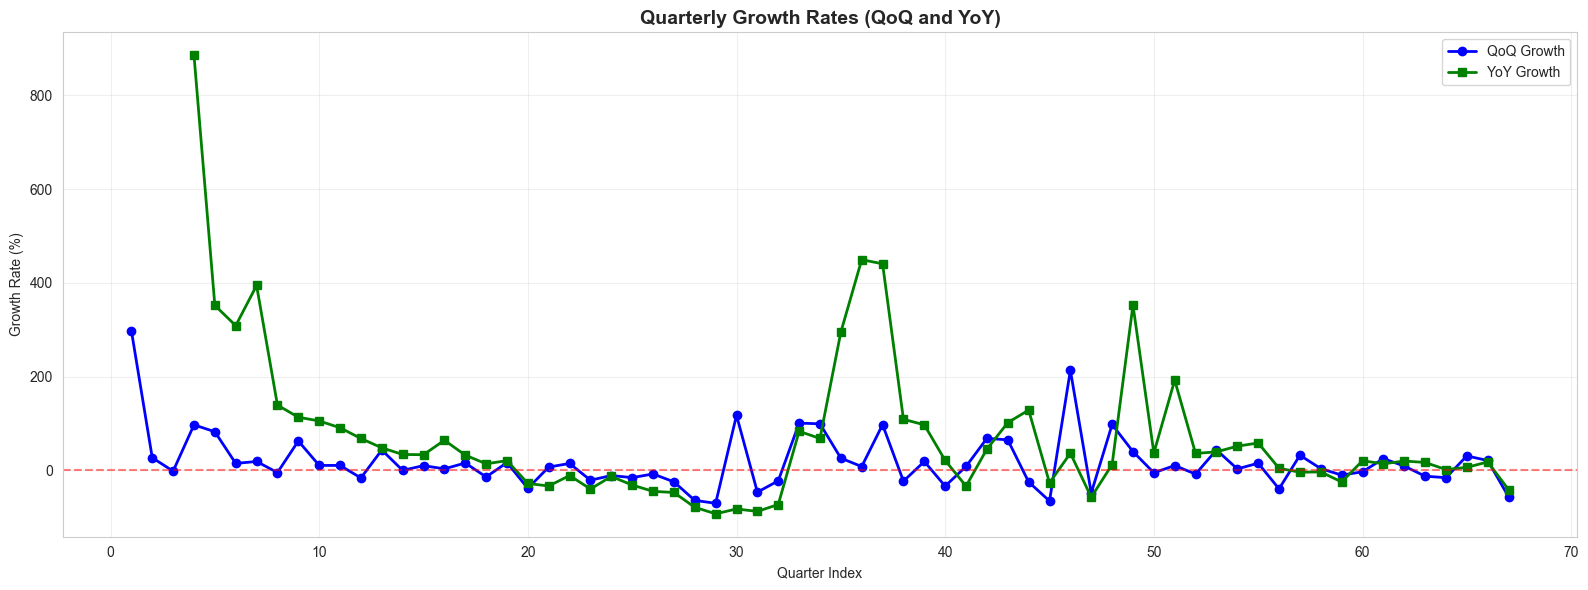

In [13]:
# Calculate quarter-over-quarter growth
quarterly['QoQ_Growth_%'] = quarterly['Total_Sales'].pct_change() * 100
quarterly['YoY_Growth_%'] = quarterly['Total_Sales'].pct_change(periods=4) * 100

print("📈 Recent Quarterly Growth Rates:\n")
display(quarterly[['year_quarter', 'Total_Sales', 'QoQ_Growth_%', 'YoY_Growth_%']].tail(12))

# Plot growth rates
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(len(quarterly)), quarterly['QoQ_Growth_%'], marker='o', linewidth=2, label='QoQ Growth', color='blue')
ax.plot(range(len(quarterly)), quarterly['YoY_Growth_%'], marker='s', linewidth=2, label='YoY Growth', color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Quarterly Growth Rates (QoQ and YoY)', fontsize=14, fontweight='bold')
ax.set_xlabel('Quarter Index')
ax.set_ylabel('Growth Rate (%)')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

---

## 5. Loan Amount Distribution

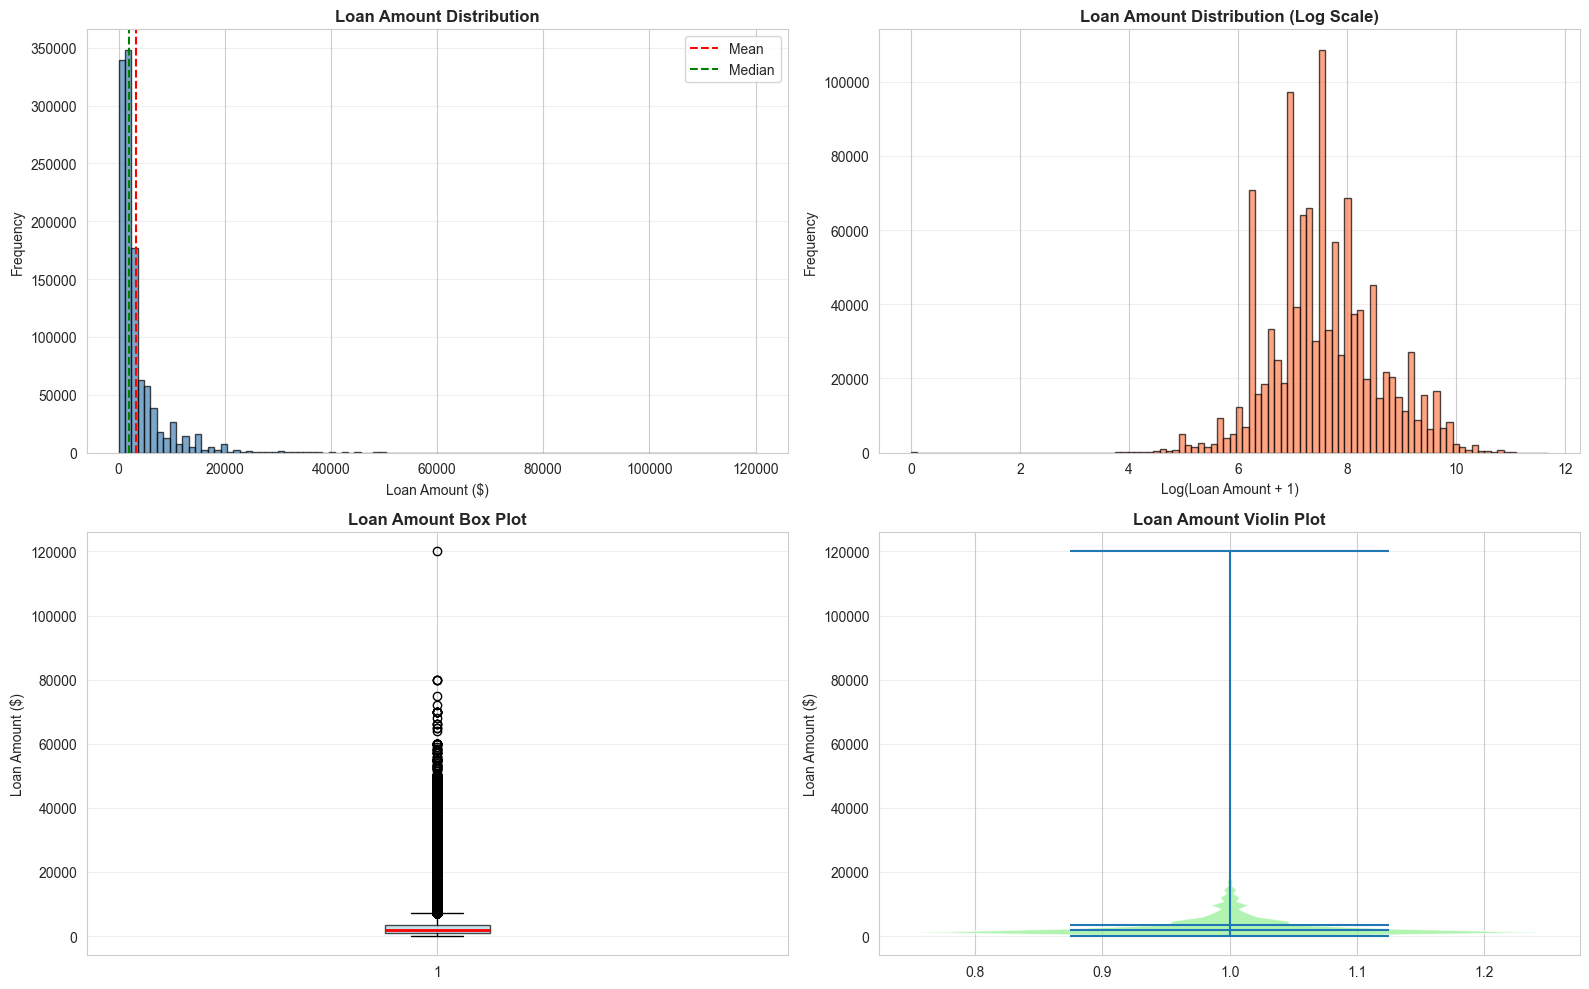

In [14]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram
axes[0, 0].hist(df_modern['loan_amount'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Loan Amount Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Loan Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_modern['loan_amount'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].axvline(df_modern['loan_amount'].median(), color='green', linestyle='--', label='Median')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Log-scale histogram
axes[0, 1].hist(np.log1p(df_modern['loan_amount']), bins=100, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Loan Amount Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log(Loan Amount + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# Box plot
axes[1, 0].boxplot(df_modern['loan_amount'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_title('Loan Amount Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loan Amount ($)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Violin plot
parts = axes[1, 1].violinplot([df_modern['loan_amount']], vert=True, showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightgreen')
    pc.set_alpha(0.7)
axes[1, 1].set_title('Loan Amount Violin Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loan Amount ($)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

📊 Loan Amount Percentiles:



,Percentile,Loan Amount
0,1%,190.00
1,5%,500.00
2,10%,500.00
3,25%,1000.00
4,50%,2000.00
5,75%,3500.00
6,90%,8000.00
7,95%,12000.00
8,99%,20000.00


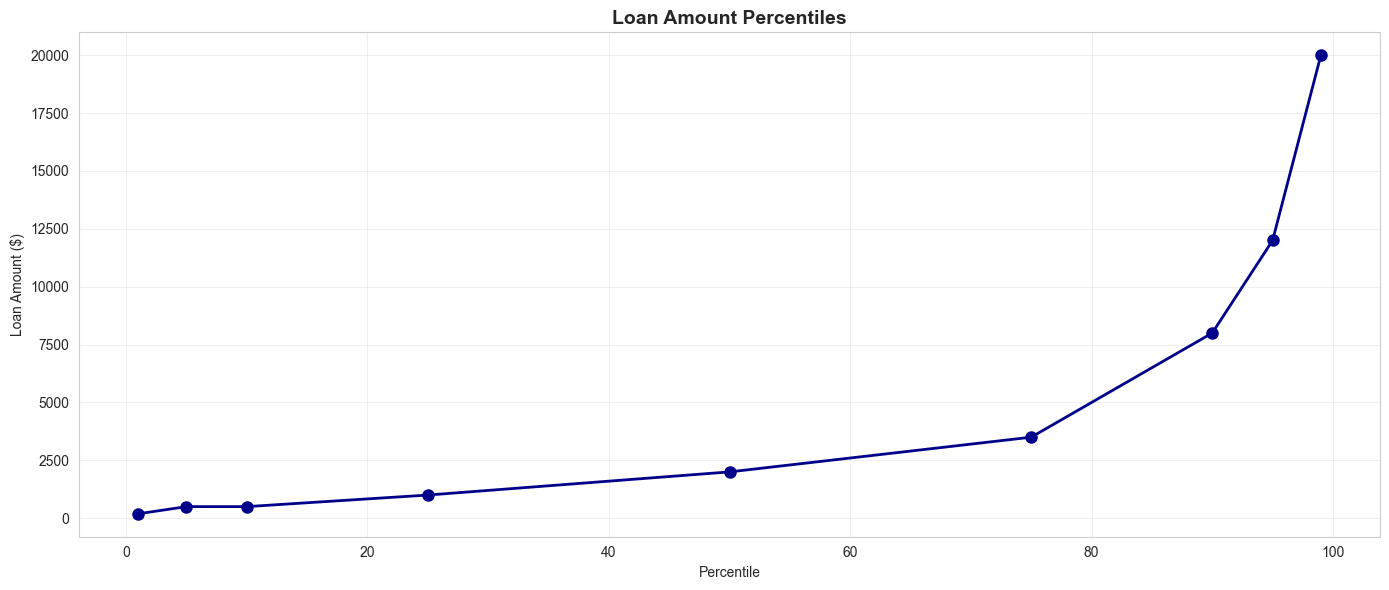

In [15]:
# Percentile analysis
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = [df_modern['loan_amount'].quantile(p/100) for p in percentiles]

percentile_df = pd.DataFrame({
    'Percentile': [f'{p}%' for p in percentiles],
    'Loan Amount': percentile_values
})

print("📊 Loan Amount Percentiles:\n")
display(percentile_df)

# Plot percentiles
plt.figure(figsize=(14, 6))
plt.plot(percentiles, percentile_values, marker='o', linewidth=2, markersize=8, color='darkblue')
plt.title('Loan Amount Percentiles', fontsize=14, fontweight='bold')
plt.xlabel('Percentile')
plt.ylabel('Loan Amount ($)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

## 6. Time Series Decomposition

Decompose quarterly sales into trend, seasonal, and residual components.

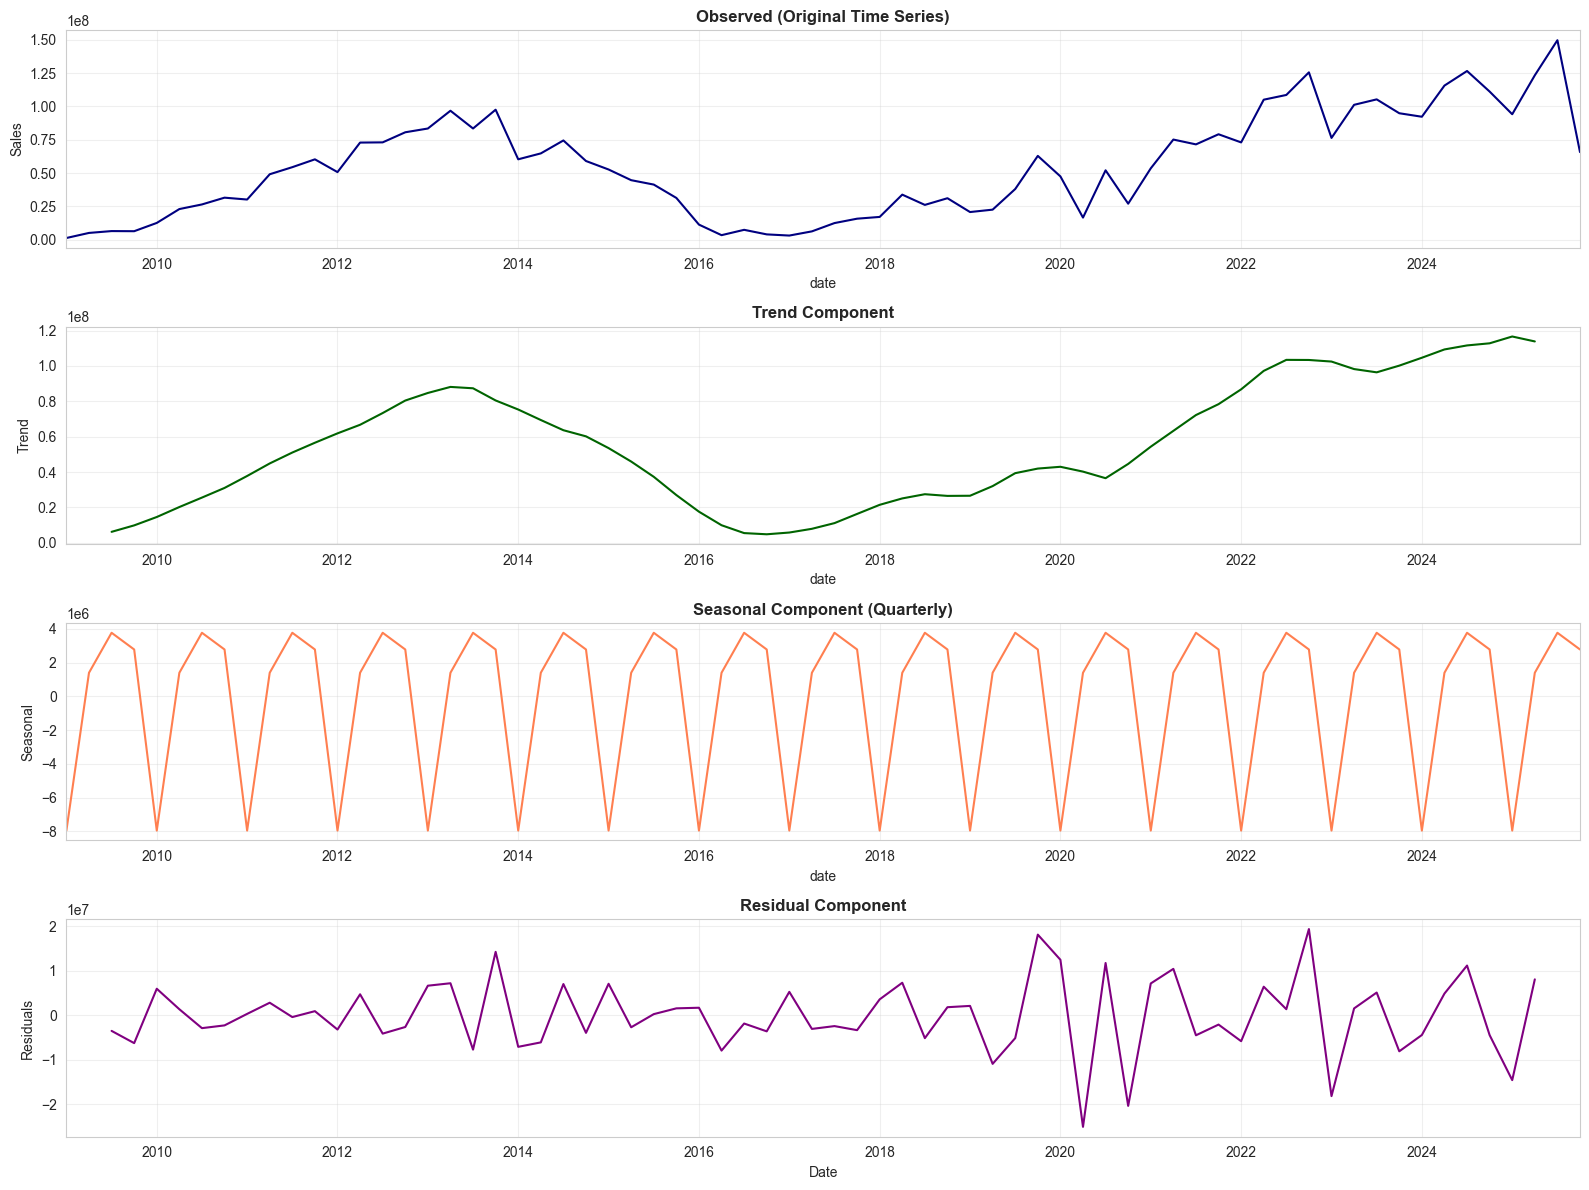

✅ Time series decomposition completed


In [16]:
# Create time series for decomposition
ts_data = quarterly[['year', 'quarter', 'Total_Sales']].copy()
ts_data['date'] = pd.to_datetime(ts_data['year'].astype(str) + '-' + 
                                   (ts_data['quarter'] * 3).astype(str) + '-01')
ts_data = ts_data.set_index('date')
ts_series = ts_data['Total_Sales']

# Perform decomposition
if len(ts_series) >= 8:  # Need at least 2 years for decomposition
    decomposition = seasonal_decompose(ts_series, model='additive', period=4)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    decomposition.observed.plot(ax=axes[0], color='navy')
    axes[0].set_title('Observed (Original Time Series)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Sales')
    axes[0].grid(alpha=0.3)
    
    decomposition.trend.plot(ax=axes[1], color='darkgreen')
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Trend')
    axes[1].grid(alpha=0.3)
    
    decomposition.seasonal.plot(ax=axes[2], color='coral')
    axes[2].set_title('Seasonal Component (Quarterly)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(alpha=0.3)
    
    decomposition.resid.plot(ax=axes[3], color='purple')
    axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Residuals')
    axes[3].set_xlabel('Date')
    axes[3].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Time series decomposition completed")
else:
    print("⚠️ Insufficient data for seasonal decomposition (need at least 8 quarters)")

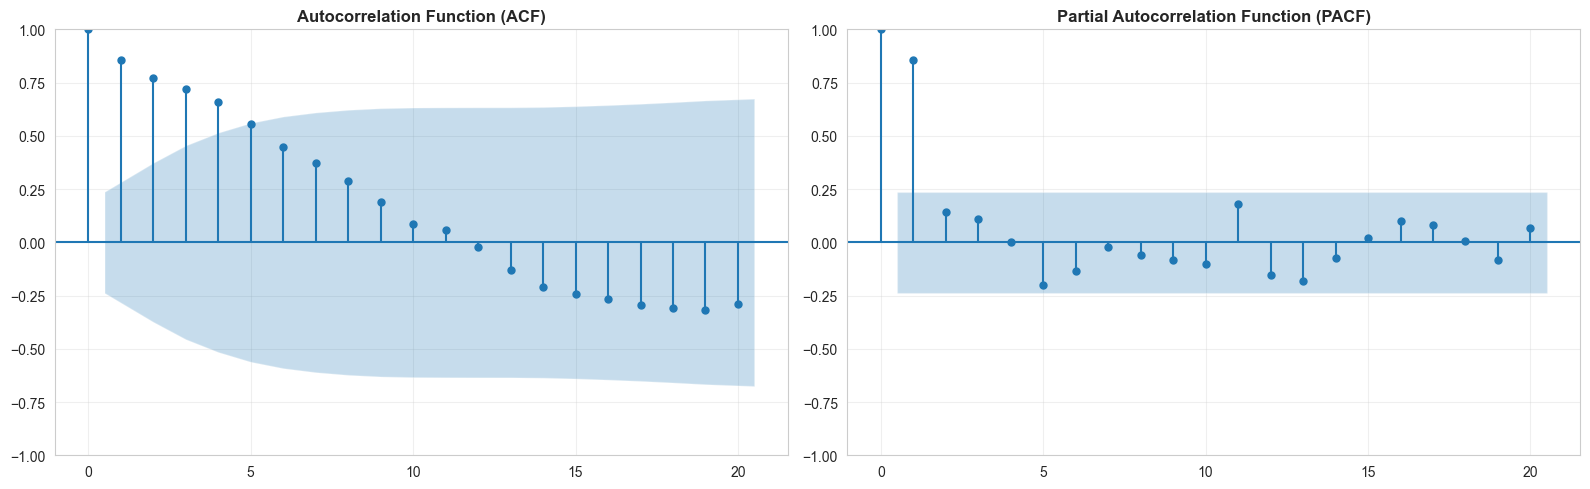

In [17]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(ts_series, lags=min(20, len(ts_series)//2), ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

plot_pacf(ts_series, lags=min(20, len(ts_series)//2), ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7. Outlier Detection

In [18]:
# IQR method for outlier detection
Q1 = df_modern['loan_amount'].quantile(0.25)
Q3 = df_modern['loan_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_modern[(df_modern['loan_amount'] < lower_bound) | (df_modern['loan_amount'] > upper_bound)]
outlier_pct = (len(outliers) / len(df_modern)) * 100

print(f"📊 Outlier Detection (IQR Method):\n")
print(f"   - Q1 (25th percentile): ${Q1:,.2f}")
print(f"   - Q3 (75th percentile): ${Q3:,.2f}")
print(f"   - IQR: ${IQR:,.2f}")
print(f"   - Lower bound: ${lower_bound:,.2f}")
print(f"   - Upper bound: ${upper_bound:,.2f}")
print(f"   - Outliers found: {len(outliers):,} ({outlier_pct:.2f}%)")
print(f"   - Outlier range: ${outliers['loan_amount'].min():,.2f} to ${outliers['loan_amount'].max():,.2f}")

📊 Outlier Detection (IQR Method):

   - Q1 (25th percentile): $1,000.00
   - Q3 (75th percentile): $3,500.00
   - IQR: $2,500.00
   - Lower bound: $-2,750.00
   - Upper bound: $7,250.00
   - Outliers found: 123,357 (10.74%)
   - Outlier range: $7,251.85 to $120,000.00


In [19]:
# Z-score method
z_scores = np.abs(stats.zscore(df_modern['loan_amount']))
outliers_z = df_modern[z_scores > 3]
outlier_z_pct = (len(outliers_z) / len(df_modern)) * 100

print(f"📊 Outlier Detection (Z-Score Method, threshold=3):\n")
print(f"   - Outliers found: {len(outliers_z):,} ({outlier_z_pct:.2f}%)")
print(f"   - Outlier range: ${outliers_z['loan_amount'].min():,.2f} to ${outliers_z['loan_amount'].max():,.2f}")

# Top 10 outliers
print(f"\n🔝 Top 10 Largest Loans:\n")
display(df_modern.nlargest(10, 'loan_amount')[['date', 'loan_amount', 'year', 'quarter']])

📊 Outlier Detection (Z-Score Method, threshold=3):

   - Outliers found: 24,643 (2.15%)
   - Outlier range: $15,940.00 to $120,000.00

🔝 Top 10 Largest Loans:



,date,loan_amount,year,quarter
1114333,2025-03-03,120000.00,2025,1
1127424,2025-06-19,80000.00,2025,2
1136711,2025-08-22,80000.00,2025,3
1147214,2025-10-31,80000.00,2025,4
1147904,2025-11-05,75000.00,2025,4
1137320,2025-08-27,72000.00,2025,3
1127488,2025-06-19,70000.00,2025,2
1140504,2025-09-17,70000.00,2025,3
1142316,2025-09-30,70000.00,2025,3
1145592,2025-10-21,70000.00,2025,4


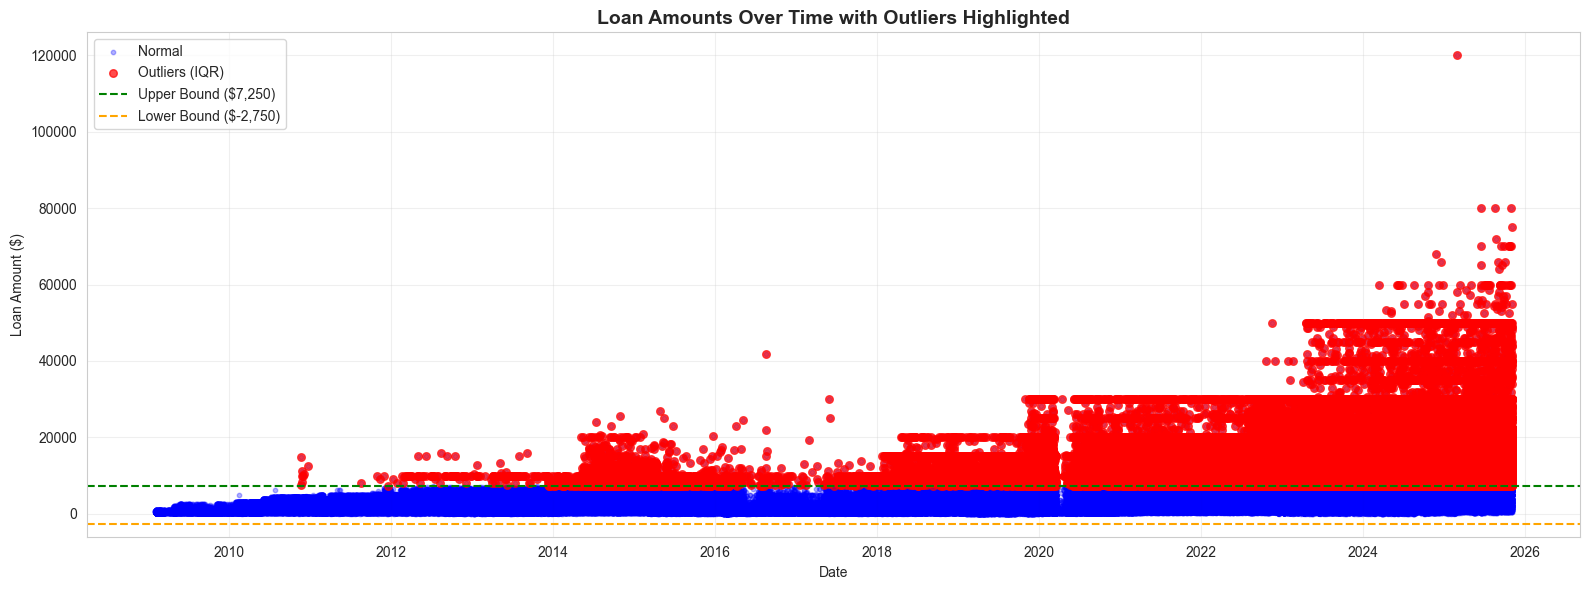

In [20]:
# Visualize outliers over time
fig, ax = plt.subplots(figsize=(16, 6))

# Plot all data
ax.scatter(df_modern['date'], df_modern['loan_amount'], alpha=0.3, s=10, label='Normal', color='blue')

# Highlight outliers
outlier_indices = outliers.index
ax.scatter(df_modern.loc[outlier_indices, 'date'], 
           df_modern.loc[outlier_indices, 'loan_amount'], 
           alpha=0.7, s=30, label='Outliers (IQR)', color='red')

ax.axhline(y=upper_bound, color='green', linestyle='--', label=f'Upper Bound (${upper_bound:,.0f})')
ax.axhline(y=lower_bound, color='orange', linestyle='--', label=f'Lower Bound (${lower_bound:,.0f})')

ax.set_title('Loan Amounts Over Time with Outliers Highlighted', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Loan Amount ($)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 8. Statistical Tests

In [21]:
# Augmented Dickey-Fuller Test (Stationarity)
print("📊 Augmented Dickey-Fuller Test (Stationarity Test):\n")

adf_result = adfuller(ts_series.dropna())
print(f"   - ADF Statistic: {adf_result[0]:.4f}")
print(f"   - p-value: {adf_result[1]:.4f}")
print(f"   - Critical Values:")
for key, value in adf_result[4].items():
    print(f"     {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print(f"\n   ✅ Reject null hypothesis - Time series is STATIONARY")
else:
    print(f"\n   ⚠️ Fail to reject null hypothesis - Time series is NON-STATIONARY")
    print(f"      Consider differencing or transformation")

📊 Augmented Dickey-Fuller Test (Stationarity Test):

   - ADF Statistic: -1.9376
   - p-value: 0.3146
   - Critical Values:
     1%: -3.5405
     5%: -2.9094
     10%: -2.5923

   ⚠️ Fail to reject null hypothesis - Time series is NON-STATIONARY
      Consider differencing or transformation


In [22]:
# KPSS Test (Trend Stationarity)
print("📊 KPSS Test (Trend Stationarity Test):\n")

kpss_result = kpss(ts_series.dropna(), regression='ct')
print(f"   - KPSS Statistic: {kpss_result[0]:.4f}")
print(f"   - p-value: {kpss_result[1]:.4f}")
print(f"   - Critical Values:")
for key, value in kpss_result[3].items():
    print(f"     {key}: {value:.4f}")

if kpss_result[1] > 0.05:
    print(f"\n   ✅ Fail to reject null hypothesis - Time series is STATIONARY")
else:
    print(f"\n   ⚠️ Reject null hypothesis - Time series is NON-STATIONARY")

📊 KPSS Test (Trend Stationarity Test):

   - KPSS Statistic: 0.1734
   - p-value: 0.0271
   - Critical Values:
     10%: 0.1190
     5%: 0.1460
     2.5%: 0.1760
     1%: 0.2160

   ⚠️ Reject null hypothesis - Time series is NON-STATIONARY


In [23]:
# Normality tests
print("📊 Normality Tests for Loan Amounts:\n")

# Shapiro-Wilk test (sample if too large)
sample_size = min(5000, len(df_modern))
sample_data = df_modern['loan_amount'].sample(sample_size, random_state=42)

shapiro_stat, shapiro_p = stats.shapiro(sample_data)
print(f"   Shapiro-Wilk Test (n={sample_size}):")
print(f"   - Statistic: {shapiro_stat:.4f}")
print(f"   - p-value: {shapiro_p:.4f}")

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.kstest(df_modern['loan_amount'], 'norm')
print(f"\n   Kolmogorov-Smirnov Test:")
print(f"   - Statistic: {ks_stat:.4f}")
print(f"   - p-value: {ks_p:.4f}")

if shapiro_p < 0.05:
    print(f"\n   ⚠️ Loan amounts are NOT normally distributed (p < 0.05)")
    print(f"      Consider log transformation for certain analyses")
else:
    print(f"\n   ✅ Loan amounts are normally distributed (p >= 0.05)")

📊 Normality Tests for Loan Amounts:

   Shapiro-Wilk Test (n=5000):
   - Statistic: 0.6251
   - p-value: 0.0000

   Kolmogorov-Smirnov Test:
   - Statistic: 1.0000
   - p-value: 0.0000

   ⚠️ Loan amounts are NOT normally distributed (p < 0.05)
      Consider log transformation for certain analyses


---

## 9. Key Insights & Recommendations

In [24]:
# Generate automated insights
print("="*80)
print("KEY INSIGHTS FROM LOAN SALES ANALYSIS")
print("="*80)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total loans analyzed: {len(df_modern):,}")
print(f"   - Time period: {df_modern['date'].min().strftime('%Y-%m-%d')} to {df_modern['date'].max().strftime('%Y-%m-%d')}")
print(f"   - Total loan volume: ${df_modern['loan_amount'].sum():,.2f}")
print(f"   - Number of quarters: {len(quarterly)}")

print(f"\n💰 LOAN AMOUNT CHARACTERISTICS:")
print(f"   - Mean loan: ${df_modern['loan_amount'].mean():,.2f}")
print(f"   - Median loan: ${df_modern['loan_amount'].median():,.2f}")
print(f"   - Std deviation: ${df_modern['loan_amount'].std():,.2f}")
print(f"   - Coefficient of variation: {(df_modern['loan_amount'].std() / df_modern['loan_amount'].mean()):.2%}")
print(f"   - Skewness: {df_modern['loan_amount'].skew():.2f} (right-skewed distribution)")

print(f"\n📈 QUARTERLY TRENDS:")
avg_quarterly_sales = quarterly['Total_Sales'].mean()
recent_quarterly_sales = quarterly['Total_Sales'].tail(4).mean()
growth = ((recent_quarterly_sales - avg_quarterly_sales) / avg_quarterly_sales) * 100
print(f"   - Average quarterly sales: ${avg_quarterly_sales:,.2f}")
print(f"   - Recent quarter average (last 4): ${recent_quarterly_sales:,.2f}")
print(f"   - Growth vs historical average: {growth:+.2f}%")

# Find best and worst quarters
best_quarter = quarterly.loc[quarterly['Total_Sales'].idxmax()]
worst_quarter = quarterly.loc[quarterly['Total_Sales'].idxmin()]
print(f"   - Best quarter: {best_quarter['year_quarter']} (${best_quarter['Total_Sales']:,.2f})")
print(f"   - Worst quarter: {worst_quarter['year_quarter']} (${worst_quarter['Total_Sales']:,.2f})")

print(f"\n🔍 OUTLIER ANALYSIS:")
print(f"   - Outliers detected (IQR): {len(outliers):,} ({outlier_pct:.2f}%)")
print(f"   - Largest loan: ${df_modern['loan_amount'].max():,.2f}")
print(f"   - Smallest loan: ${df_modern['loan_amount'].min():,.2f}")

print(f"\n📊 STATIONARITY:")
if adf_result[1] < 0.05:
    print(f"   ✅ Time series is stationary (ADF p-value: {adf_result[1]:.4f})")
else:
    print(f"   ⚠️ Time series is non-stationary (ADF p-value: {adf_result[1]:.4f})")
    print(f"      Recommendation: Apply differencing for ARIMA modeling")

print(f"\n💡 RECOMMENDATIONS FOR FORECASTING:")
print(f"   1. Use quarterly aggregation (Total_Sales) as target variable")
print(f"   2. Consider STL decomposition for seasonal adjustment")
print(f"   3. Handle outliers appropriately (cap at {upper_bound:,.0f} or use robust methods)")
print(f"   4. Test both ARIMA/SARIMA and simple methods (SMA, ETS) as per research")
print(f"   5. Use recent {min(8, len(quarterly))} quarters for validation")
print(f"   6. Monitor quarter-over-quarter volatility ({quarterly['QoQ_Growth_%'].std():.2f}% std)")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)

KEY INSIGHTS FROM LOAN SALES ANALYSIS

📊 DATASET OVERVIEW:
   - Total loans analyzed: 1,148,302
   - Time period: 2009-01-29 to 2025-11-06
   - Total loan volume: $3,778,636,979.34
   - Number of quarters: 68

💰 LOAN AMOUNT CHARACTERISTICS:
   - Mean loan: $3,290.63
   - Median loan: $2,000.00
   - Std deviation: $4,215.63
   - Coefficient of variation: 128.11%
   - Skewness: 3.67 (right-skewed distribution)

📈 QUARTERLY TRENDS:
   - Average quarterly sales: $55,568,190.87
   - Recent quarter average (last 4): $108,159,537.31
   - Growth vs historical average: +94.64%
   - Best quarter: 2025-Q3 ($149,584,441.28)
   - Worst quarter: 2009-Q1 ($1,275,799.00)

🔍 OUTLIER ANALYSIS:
   - Outliers detected (IQR): 123,357 (10.74%)
   - Largest loan: $120,000.00
   - Smallest loan: $0.00

📊 STATIONARITY:
   ⚠️ Time series is non-stationary (ADF p-value: 0.3146)
      Recommendation: Apply differencing for ARIMA modeling

💡 RECOMMENDATIONS FOR FORECASTING:
   1. Use quarterly aggregation (Total_S

In [25]:
# Export summary statistics
summary_dict = {
    'total_loans': len(df_modern),
    'date_range_start': df_modern['date'].min().strftime('%Y-%m-%d'),
    'date_range_end': df_modern['date'].max().strftime('%Y-%m-%d'),
    'total_volume': float(df_modern['loan_amount'].sum()),
    'mean_loan': float(df_modern['loan_amount'].mean()),
    'median_loan': float(df_modern['loan_amount'].median()),
    'std_loan': float(df_modern['loan_amount'].std()),
    'num_quarters': len(quarterly),
    'avg_quarterly_sales': float(quarterly['Total_Sales'].mean()),
    'outlier_percentage': float(outlier_pct),
    'adf_pvalue': float(adf_result[1]),
    'is_stationary': bool(adf_result[1] < 0.05)
}

summary_df = pd.DataFrame([summary_dict])
summary_df.to_csv('data/analysis_summary.csv', index=False)

print("💾 Analysis summary saved to: data/analysis_summary.csv")
print("\n📊 Summary Statistics:")
display(summary_df.T)

💾 Analysis summary saved to: data/analysis_summary.csv

📊 Summary Statistics:


,0
total_loans,1148302
date_range_start,2009-01-29
date_range_end,2025-11-06
total_volume,3778636979.34
mean_loan,3290.63
median_loan,2000.00
std_loan,4215.63
num_quarters,68
avg_quarterly_sales,55568190.87
outlier_percentage,10.74
